In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

import sklearn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# scipy sparse matrix
import scipy
from scipy.sparse import hstack

import seaborn as sns
import matplotlib.pyplot as plt
from voting_utils import WeightFinding_sklearn
from nltk.stem.snowball import SnowballStemmer
wnl = SnowballStemmer('english')
from scipy.sparse import vstack
from tqdm import tqdm
from voting_utils import voting
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
# Data Preprocessing & Data Cleaning
def url_parser(url):
    try:
        pattern = re.compile(r'^(?P<protocal>.*?)://(?P<domainname>.*?)(/(?P<uri>.*?))?$')
        groups = re.match(pattern, url).groupdict()
    except Exception as e:
        groups = {'protocal': ' ', 'domainname': ' ', 'uri': ' '}
    return groups


def tokenize_and_lemmatize(s):
    s = s if s else ''
    try:
        tokens = filter(lambda x: x != '', re.split(r'\W', s))
        # http//www.hundreddogs-cats.com
        # www, hundreddogs, cats, com
        tokens = map(lambda t: wnl.stem(t), tokens)
        tokens = list(tokens)
    except Exception as e:
        tokens = []
        
    return ' '.join(tokens)


def parse_dataset(df):
    url_groups = list(map(url_parser, df['url']))
    df = pd.concat([df, pd.DataFrame.from_dict(url_groups)], axis=1)
    
    df['domainname'] = list(map(tokenize_and_lemmatize, df['domainname']))
    df['uri'] = list(map(tokenize_and_lemmatize, df['uri']))
    
    return df

## MNB model

In [3]:
df = pd.read_csv('dmoz.csv', header=None)
df.columns = ["index", "url", "label"]
df

,index,url,label
0,1,http://www.liquidgeneration.com/,Adult
1,2,http://www.onlineanime.org/,Adult
2,3,http://www.ceres.dti.ne.jp/~nekoi/senno/senfir...,Adult
3,4,http://www.galeon.com/kmh/,Adult
4,5,http://www.fanworkrecs.com/,Adult
...,...,...,...
1562973,1562974,http://www.maxpreps.com/,Sports
1562974,1562975,http://www.myscore.com/,Sports
1562975,1562976,http://sportsillustrated.cnn.com/highschool,Sports
1562976,1562977,http://rss.cnn.com/rss/si_highschool?format=xml,Sports


Text(0.5, 0, 'labels')

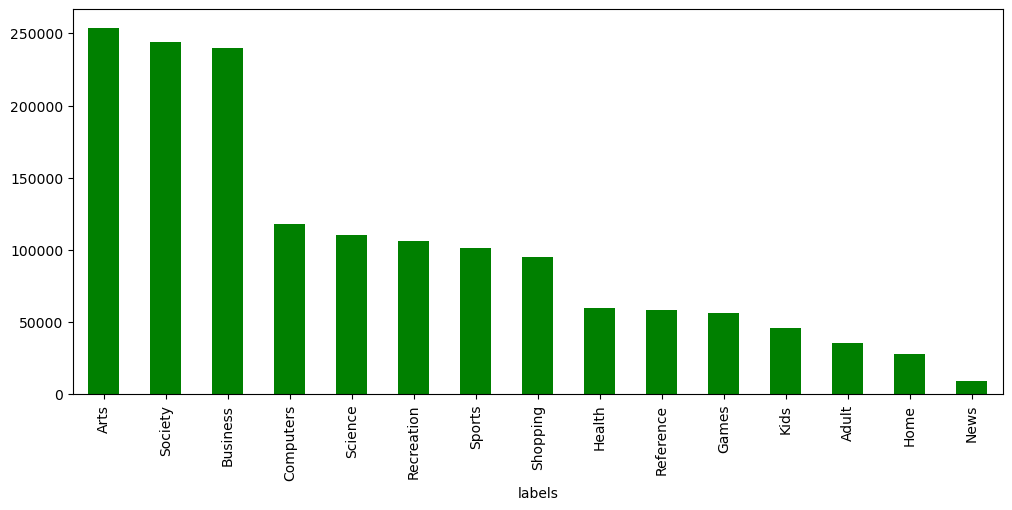

In [4]:
df['label'].value_counts().plot(figsize=(12,5),kind='bar',color='green');
plt.xlabel('labels')

In [5]:
num_samples = len(df)
df = df[0:num_samples]

In [6]:
print(f"Parsing {len(df)} rows dataset...")
df = parse_dataset(df)

print("Done")

Parsing 1562978 rows dataset...
Done


In [7]:
unique_labels = set(df['label'])
label2idx = {k: i for i, k in enumerate(unique_labels)}
idx2label = {i: k for i, k in enumerate(unique_labels)}

In [8]:
df['label'] = df['label'].map(label2idx)

In [9]:
print("Training domainname vectorizer")
domainname_tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1)).fit(df['domainname'])

print("Training uri vectorizer")
uri_tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 3)).fit(df['uri'])

Training domainname vectorizer
Training uri vectorizer


In [10]:
X = hstack((
    domainname_tfidf_vectorizer.transform(df['domainname']), 
    uri_tfidf_vectorizer.transform(df['uri'])
))

y = df['label'].values

X.shape, y.shape

((1562978, 2770911), (1562978,))

In [11]:
def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    X_train_list = []
    X_test_list = []
    y_train_list = []
    y_test_list = []

    for class_label in np.unique(y):
        X_class = X[y == class_label]
        y_class = y[y == class_label]
        
        X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
            X_class, y_class, test_size=test_size, random_state=random_state
        )
        
        X_train_list.append(X_class_train)
        X_test_list.append(X_class_test)
        y_train_list.append(y_class_train)
        y_test_list.append(y_class_test)
    
    X_train = vstack(X_train_list)
    X_test = vstack(X_test_list)
    
    y_train = np.hstack(y_train_list)
    y_test = np.hstack(y_test_list)
    
    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = stratified_train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

def train_noisy_MNB(n_models, X_train, y_train, unique_labels):
    clfs = []
    p = 1/n_models - 0.02
    for i in range(n_models):
        clf = sklearn.naive_bayes.MultinomialNB()
        X_train_part, X_test_part, y_train_part, y_test_part = stratified_train_test_split(X_train, y_train, test_size=0.2)
        flip_indices = np.random.choice(range(len(y_train_part)), int(i * p * len(y_train_part)), replace=False)
        y_train_part[flip_indices] = len(unique_labels) - 1 - y_train_part[flip_indices]
        clf.fit(X_train_part, y_train_part)
        clfs.append(clf)
    return clfs

In [15]:
def experiment(divs, n):
    accuracy_dict = {}
    accuracy_dict['accuracy'] = {}
    accuracy_dict['shapley'] = {}
    accuracy_dict['loo'] = {}
    accuracy_dict['entropy'] = {}
    accuracy_dict['crh'] = {}
    accuracy_dict['regression'] = {}
    accuracy_dict['unweighted'] = {}

    for key in accuracy_dict.keys():
        accuracy_dict[key]['borda'] = []
        accuracy_dict[key]['plurality'] = []

    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = stratified_train_test_split(X, y, test_size=0.3)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
        clfs = train_noisy_MNB(divs, X_train, y_train, unique_labels)
        wf = WeightFinding_sklearn(clfs, [X_val, y_val], 'cpu')
        wf_test = WeightFinding_sklearn(clfs, [X_test, y_test], 'cpu')
        loo_weights = wf.loo()
        shapley_weights = wf.shapley()
        crh_weights = wf.crh()
        regression_weights = wf.regression()
        acc_weights = wf.accuracy_weights()
        entropy_weights = wf.entropy_weights()
        
        accuracy_dict['accuracy']['borda'].append(voting(wf_test.y_preds, wf_test.labels, acc_weights, method='borda'))
        accuracy_dict['accuracy']['plurality'].append(voting(wf_test.y_preds, wf_test.labels, acc_weights, method='plurality'))
        accuracy_dict['shapley']['borda'].append(voting(wf_test.y_preds, wf_test.labels, shapley_weights, method='borda'))
        accuracy_dict['shapley']['plurality'].append(voting(wf_test.y_preds, wf_test.labels, shapley_weights, method='plurality'))
        accuracy_dict['loo']['borda'].append(voting(wf_test.y_preds, wf_test.labels, loo_weights, method='borda'))
        accuracy_dict['loo']['plurality'].append(voting(wf_test.y_preds, wf_test.labels, loo_weights, method='plurality'))
        accuracy_dict['entropy']['borda'].append(voting(wf_test.y_preds, wf_test.labels, entropy_weights, method='borda'))
        accuracy_dict['entropy']['plurality'].append(voting(wf_test.y_preds, wf_test.labels, entropy_weights, method='plurality'))
        accuracy_dict['crh']['borda'].append(voting(wf_test.y_preds, wf_test.labels, crh_weights, method='borda'))
        accuracy_dict['crh']['plurality'].append(voting(wf_test.y_preds, wf_test.labels, crh_weights, method='plurality'))
        accuracy_dict['regression']['borda'].append(voting(wf_test.y_preds, wf_test.labels, regression_weights, method='borda'))
        accuracy_dict['regression']['plurality'].append(voting(wf_test.y_preds, wf_test.labels, regression_weights, method='plurality'))
        accuracy_dict['unweighted']['borda'].append(voting(wf_test.y_preds, wf_test.labels, weights = None, method='borda'))
        accuracy_dict['unweighted']['plurality'].append(voting(wf_test.y_preds, wf_test.labels, weights = None, method='plurality'))
    return accuracy_dict

In [16]:
accuracy_dict_3 = experiment(3, 10)
accuracy_dict_5 = experiment(5, 10)
accuracy_dict_7 = experiment(7, 10)
accuracy_dict_10 = experiment(10, 10)

100%|██████████| 3/3 [00:00<00:00,  7.09it/s]


Calculating LOO values for 3 models
Calculating Shapley values for 3 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 3/3 [00:00<00:00, 39077.37it/s]


Calculating CRH values for 3 models
Calculating Regression weights for 3 models


100%|██████████| 1000/1000 [00:32<00:00, 30.53it/s]


Calculating Accuracy weights for 3 models
Calculating Entropy weights for 3 models


100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


Calculating LOO values for 3 models
Calculating Shapley values for 3 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 3/3 [00:00<00:00, 49539.02it/s]


Calculating CRH values for 3 models
Calculating Regression weights for 3 models


100%|██████████| 1000/1000 [00:25<00:00, 38.52it/s]


Calculating Accuracy weights for 3 models
Calculating Entropy weights for 3 models


100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


Calculating LOO values for 3 models
Calculating Shapley values for 3 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 3/3 [00:00<00:00, 54471.48it/s]


Calculating CRH values for 3 models
Calculating Regression weights for 3 models


100%|██████████| 1000/1000 [00:24<00:00, 41.01it/s]


Calculating Accuracy weights for 3 models
Calculating Entropy weights for 3 models


100%|██████████| 3/3 [00:00<00:00,  7.41it/s]


Calculating LOO values for 3 models
Calculating Shapley values for 3 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 3/3 [00:00<00:00, 59353.36it/s]


Calculating CRH values for 3 models
Calculating Regression weights for 3 models


100%|██████████| 1000/1000 [00:24<00:00, 40.61it/s]


Calculating Accuracy weights for 3 models
Calculating Entropy weights for 3 models


100%|██████████| 3/3 [00:00<00:00,  7.28it/s]


Calculating LOO values for 3 models
Calculating Shapley values for 3 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 3/3 [00:00<00:00, 48210.39it/s]


Calculating CRH values for 3 models
Calculating Regression weights for 3 models


100%|██████████| 1000/1000 [00:24<00:00, 40.35it/s]


Calculating Accuracy weights for 3 models
Calculating Entropy weights for 3 models


100%|██████████| 3/3 [00:00<00:00,  7.26it/s]


Calculating LOO values for 3 models
Calculating Shapley values for 3 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 3/3 [00:00<00:00, 55924.05it/s]


Calculating CRH values for 3 models
Calculating Regression weights for 3 models


100%|██████████| 1000/1000 [00:25<00:00, 38.82it/s]


Calculating Accuracy weights for 3 models
Calculating Entropy weights for 3 models


100%|██████████| 3/3 [00:00<00:00,  7.34it/s]


Calculating LOO values for 3 models
Calculating Shapley values for 3 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 3/3 [00:00<00:00, 53773.13it/s]


Calculating CRH values for 3 models
Calculating Regression weights for 3 models


100%|██████████| 1000/1000 [00:23<00:00, 42.72it/s]


Calculating Accuracy weights for 3 models
Calculating Entropy weights for 3 models


100%|██████████| 3/3 [00:00<00:00,  7.39it/s]


Calculating LOO values for 3 models
Calculating Shapley values for 3 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 3/3 [00:00<00:00, 48026.38it/s]


Calculating CRH values for 3 models
Calculating Regression weights for 3 models


100%|██████████| 1000/1000 [00:24<00:00, 40.58it/s]


Calculating Accuracy weights for 3 models
Calculating Entropy weights for 3 models


100%|██████████| 3/3 [00:00<00:00,  7.23it/s]


Calculating LOO values for 3 models
Calculating Shapley values for 3 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 3/3 [00:00<00:00, 50737.55it/s]


Calculating CRH values for 3 models
Calculating Regression weights for 3 models


100%|██████████| 1000/1000 [00:24<00:00, 40.86it/s]


Calculating Accuracy weights for 3 models
Calculating Entropy weights for 3 models


100%|██████████| 3/3 [00:00<00:00,  7.32it/s]


Calculating LOO values for 3 models
Calculating Shapley values for 3 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 3/3 [00:00<00:00, 3390.71it/s]


Calculating CRH values for 3 models
Calculating Regression weights for 3 models


100%|██████████| 1000/1000 [00:23<00:00, 41.90it/s]


Calculating Accuracy weights for 3 models
Calculating Entropy weights for 3 models


100%|██████████| 5/5 [00:00<00:00,  7.35it/s]


Calculating LOO values for 5 models
Calculating Shapley values for 5 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 5/5 [00:00<00:00, 40329.85it/s]


Calculating CRH values for 5 models
Calculating Regression weights for 5 models


100%|██████████| 1000/1000 [00:36<00:00, 27.15it/s]


Calculating Accuracy weights for 5 models
Calculating Entropy weights for 5 models


100%|██████████| 5/5 [00:00<00:00,  7.36it/s]


Calculating LOO values for 5 models
Calculating Shapley values for 5 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 5/5 [00:00<00:00, 40252.44it/s]


Calculating CRH values for 5 models
Calculating Regression weights for 5 models


100%|██████████| 1000/1000 [00:36<00:00, 27.34it/s]


Calculating Accuracy weights for 5 models
Calculating Entropy weights for 5 models


100%|██████████| 5/5 [00:00<00:00,  7.23it/s]


Calculating LOO values for 5 models
Calculating Shapley values for 5 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 5/5 [00:00<00:00, 48321.47it/s]


Calculating CRH values for 5 models
Calculating Regression weights for 5 models


100%|██████████| 1000/1000 [00:37<00:00, 26.42it/s]


Calculating Accuracy weights for 5 models
Calculating Entropy weights for 5 models


100%|██████████| 5/5 [00:00<00:00,  7.39it/s]


Calculating LOO values for 5 models
Calculating Shapley values for 5 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 5/5 [00:00<00:00, 43965.45it/s]


Calculating CRH values for 5 models
Calculating Regression weights for 5 models


100%|██████████| 1000/1000 [00:38<00:00, 26.30it/s]


Calculating Accuracy weights for 5 models
Calculating Entropy weights for 5 models


100%|██████████| 5/5 [00:00<00:00,  7.39it/s]


Calculating LOO values for 5 models
Calculating Shapley values for 5 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 5/5 [00:00<00:00, 47554.47it/s]


Calculating CRH values for 5 models
Calculating Regression weights for 5 models


100%|██████████| 1000/1000 [00:36<00:00, 27.31it/s]


Calculating Accuracy weights for 5 models
Calculating Entropy weights for 5 models


100%|██████████| 5/5 [00:00<00:00,  7.40it/s]


Calculating LOO values for 5 models
Calculating Shapley values for 5 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 5/5 [00:00<00:00, 44431.19it/s]


Calculating CRH values for 5 models
Calculating Regression weights for 5 models


100%|██████████| 1000/1000 [00:36<00:00, 27.04it/s]


Calculating Accuracy weights for 5 models
Calculating Entropy weights for 5 models


100%|██████████| 5/5 [00:00<00:00,  7.33it/s]


Calculating LOO values for 5 models
Calculating Shapley values for 5 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 5/5 [00:00<00:00, 41445.69it/s]


Calculating CRH values for 5 models
Calculating Regression weights for 5 models


100%|██████████| 1000/1000 [00:35<00:00, 28.13it/s]


Calculating Accuracy weights for 5 models
Calculating Entropy weights for 5 models


100%|██████████| 5/5 [00:00<00:00,  7.28it/s]


Calculating LOO values for 5 models
Calculating Shapley values for 5 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 5/5 [00:00<00:00, 44150.57it/s]


Calculating CRH values for 5 models
Calculating Regression weights for 5 models


100%|██████████| 1000/1000 [00:36<00:00, 27.03it/s]


Calculating Accuracy weights for 5 models
Calculating Entropy weights for 5 models


100%|██████████| 5/5 [00:00<00:00,  7.25it/s]


Calculating LOO values for 5 models
Calculating Shapley values for 5 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 5/5 [00:00<00:00, 47127.01it/s]


Calculating CRH values for 5 models
Calculating Regression weights for 5 models


100%|██████████| 1000/1000 [00:36<00:00, 27.25it/s]


Calculating Accuracy weights for 5 models
Calculating Entropy weights for 5 models


100%|██████████| 5/5 [00:00<00:00,  7.07it/s]


Calculating LOO values for 5 models
Calculating Shapley values for 5 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 5/5 [00:00<00:00, 39794.16it/s]


Calculating CRH values for 5 models
Calculating Regression weights for 5 models


100%|██████████| 1000/1000 [00:37<00:00, 26.97it/s]


Calculating Accuracy weights for 5 models
Calculating Entropy weights for 5 models


100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Calculating LOO values for 7 models
Calculating Shapley values for 7 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 7/7 [00:00<00:00, 19797.79it/s]


Calculating CRH values for 7 models
Calculating Regression weights for 7 models


100%|██████████| 1000/1000 [00:48<00:00, 20.46it/s]


Calculating Accuracy weights for 7 models
Calculating Entropy weights for 7 models


100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Calculating LOO values for 7 models
Calculating Shapley values for 7 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 7/7 [00:00<00:00, 19534.35it/s]


Calculating CRH values for 7 models
Calculating Regression weights for 7 models


100%|██████████| 1000/1000 [00:48<00:00, 20.41it/s]


Calculating Accuracy weights for 7 models
Calculating Entropy weights for 7 models


100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Calculating LOO values for 7 models
Calculating Shapley values for 7 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 7/7 [00:00<00:00, 16540.92it/s]


Calculating CRH values for 7 models
Calculating Regression weights for 7 models


100%|██████████| 1000/1000 [00:49<00:00, 20.29it/s]


Calculating Accuracy weights for 7 models
Calculating Entropy weights for 7 models


100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Calculating LOO values for 7 models
Calculating Shapley values for 7 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 7/7 [00:00<00:00, 18617.71it/s]


Calculating CRH values for 7 models
Calculating Regression weights for 7 models


100%|██████████| 1000/1000 [00:49<00:00, 20.35it/s]


Calculating Accuracy weights for 7 models
Calculating Entropy weights for 7 models


100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Calculating LOO values for 7 models
Calculating Shapley values for 7 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 7/7 [00:00<00:00, 19625.75it/s]


Calculating CRH values for 7 models
Calculating Regression weights for 7 models


100%|██████████| 1000/1000 [00:49<00:00, 20.35it/s]


Calculating Accuracy weights for 7 models
Calculating Entropy weights for 7 models


100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Calculating LOO values for 7 models
Calculating Shapley values for 7 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 7/7 [00:00<00:00, 19638.88it/s]


Calculating CRH values for 7 models
Calculating Regression weights for 7 models


100%|██████████| 1000/1000 [00:49<00:00, 20.29it/s]


Calculating Accuracy weights for 7 models
Calculating Entropy weights for 7 models


100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Calculating LOO values for 7 models
Calculating Shapley values for 7 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 7/7 [00:00<00:00, 18724.57it/s]


Calculating CRH values for 7 models
Calculating Regression weights for 7 models


100%|██████████| 1000/1000 [00:49<00:00, 20.39it/s]


Calculating Accuracy weights for 7 models
Calculating Entropy weights for 7 models


100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


Calculating LOO values for 7 models
Calculating Shapley values for 7 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 7/7 [00:00<00:00, 19214.74it/s]


Calculating CRH values for 7 models
Calculating Regression weights for 7 models


100%|██████████| 1000/1000 [00:48<00:00, 20.51it/s]


Calculating Accuracy weights for 7 models
Calculating Entropy weights for 7 models


100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Calculating LOO values for 7 models
Calculating Shapley values for 7 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 7/7 [00:00<00:00, 19757.83it/s]


Calculating CRH values for 7 models
Calculating Regression weights for 7 models


100%|██████████| 1000/1000 [00:49<00:00, 20.09it/s]


Calculating Accuracy weights for 7 models
Calculating Entropy weights for 7 models


100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Calculating LOO values for 7 models
Calculating Shapley values for 7 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 7/7 [00:00<00:00, 19986.47it/s]


Calculating CRH values for 7 models
Calculating Regression weights for 7 models


100%|██████████| 1000/1000 [00:49<00:00, 20.38it/s]


Calculating Accuracy weights for 7 models
Calculating Entropy weights for 7 models


100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


Calculating LOO values for 10 models
Calculating Shapley values for 10 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 10/10 [00:00<00:00, 2916.76it/s]


Calculating CRH values for 10 models
Calculating Regression weights for 10 models


100%|██████████| 1000/1000 [00:52<00:00, 19.12it/s]


Calculating Accuracy weights for 10 models
Calculating Entropy weights for 10 models


100%|██████████| 10/10 [00:01<00:00,  7.38it/s]


Calculating LOO values for 10 models
Calculating Shapley values for 10 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 10/10 [00:00<00:00, 2858.13it/s]


Calculating CRH values for 10 models
Calculating Regression weights for 10 models


100%|██████████| 1000/1000 [01:08<00:00, 14.59it/s]


Calculating Accuracy weights for 10 models
Calculating Entropy weights for 10 models


100%|██████████| 10/10 [00:01<00:00,  7.29it/s]


Calculating LOO values for 10 models
Calculating Shapley values for 10 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 10/10 [00:00<00:00, 2925.10it/s]


Calculating CRH values for 10 models
Calculating Regression weights for 10 models


100%|██████████| 1000/1000 [01:08<00:00, 14.54it/s]


Calculating Accuracy weights for 10 models
Calculating Entropy weights for 10 models


100%|██████████| 10/10 [00:01<00:00,  7.33it/s]


Calculating LOO values for 10 models
Calculating Shapley values for 10 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 10/10 [00:00<00:00, 2898.62it/s]


Calculating CRH values for 10 models
Calculating Regression weights for 10 models


100%|██████████| 1000/1000 [01:08<00:00, 14.66it/s]


Calculating Accuracy weights for 10 models
Calculating Entropy weights for 10 models


100%|██████████| 10/10 [00:01<00:00,  7.34it/s]


Calculating LOO values for 10 models
Calculating Shapley values for 10 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 10/10 [00:00<00:00, 2952.90it/s]


Calculating CRH values for 10 models
Calculating Regression weights for 10 models


100%|██████████| 1000/1000 [01:08<00:00, 14.64it/s]


Calculating Accuracy weights for 10 models
Calculating Entropy weights for 10 models


100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Calculating LOO values for 10 models
Calculating Shapley values for 10 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 10/10 [00:00<00:00, 2922.25it/s]


Calculating CRH values for 10 models
Calculating Regression weights for 10 models


100%|██████████| 1000/1000 [01:09<00:00, 14.46it/s]


Calculating Accuracy weights for 10 models
Calculating Entropy weights for 10 models


100%|██████████| 10/10 [00:01<00:00,  7.35it/s]


Calculating LOO values for 10 models
Calculating Shapley values for 10 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 10/10 [00:00<00:00, 2907.06it/s]


Calculating CRH values for 10 models
Calculating Regression weights for 10 models


100%|██████████| 1000/1000 [01:09<00:00, 14.43it/s]


Calculating Accuracy weights for 10 models
Calculating Entropy weights for 10 models


100%|██████████| 10/10 [00:01<00:00,  7.37it/s]


Calculating LOO values for 10 models
Calculating Shapley values for 10 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 10/10 [00:00<00:00, 2908.87it/s]


Calculating CRH values for 10 models
Calculating Regression weights for 10 models


100%|██████████| 1000/1000 [01:09<00:00, 14.42it/s]


Calculating Accuracy weights for 10 models
Calculating Entropy weights for 10 models


100%|██████████| 10/10 [00:01<00:00,  7.34it/s]


Calculating LOO values for 10 models
Calculating Shapley values for 10 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 10/10 [00:00<00:00, 2893.42it/s]


Calculating CRH values for 10 models
Calculating Regression weights for 10 models


100%|██████████| 1000/1000 [01:08<00:00, 14.50it/s]


Calculating Accuracy weights for 10 models
Calculating Entropy weights for 10 models


100%|██████████| 10/10 [00:01<00:00,  7.32it/s]


Calculating LOO values for 10 models
Calculating Shapley values for 10 models


/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 10/10 [00:00<00:00, 2873.80it/s]


Calculating CRH values for 10 models
Calculating Regression weights for 10 models


100%|██████████| 1000/1000 [01:09<00:00, 14.48it/s]


Calculating Accuracy weights for 10 models
Calculating Entropy weights for 10 models


100%|██████████| 10/10 [24:58<00:00, 149.86s/it]


In [17]:
# Save the dictionaries in a pickle file in destination folder dmoz_exps/ create the folder if it does not exist
import pickle
import os
if not os.path.exists('dmoz_exps'):
    os.makedirs('dmoz_exps')
with open('dmoz_exps/accuracy_dict_3.pkl', 'wb') as f:
    pickle.dump(accuracy_dict_3, f)
with open('dmoz_exps/accuracy_dict_5.pkl', 'wb') as f:
    pickle.dump(accuracy_dict_5, f)
with open('dmoz_exps/accuracy_dict_7.pkl', 'wb') as f:
    pickle.dump(accuracy_dict_7, f)
with open('dmoz_exps/accuracy_dict_10.pkl', 'wb') as f:
    pickle.dump(accuracy_dict_10, f)

# Load the dictionaries from the pickle file
with open('dmoz_exps/accuracy_dict_3.pkl', 'rb') as f:
    accuracy_dict_3 = pickle.load(f)
with open('dmoz_exps/accuracy_dict_5.pkl', 'rb') as f:
    accuracy_dict_5 = pickle.load(f)
with open('dmoz_exps/accuracy_dict_7.pkl', 'rb') as f:
    accuracy_dict_7 = pickle.load(f)
with open('dmoz_exps/accuracy_dict_10.pkl', 'rb') as f:
    accuracy_dict_10 = pickle.load(f)

In [18]:
accuracy_bordas_3 = {key:accuracy_dict_3[key]['borda'] for key in accuracy_dict_3.keys()}
accuracy_plurality_3 = {key:accuracy_dict_3[key]['plurality'] for key in accuracy_dict_3.keys()}

accuracy_bordas_3_df = pd.DataFrame(accuracy_bordas_3)
accuracy_plurality_3_df = pd.DataFrame(accuracy_plurality_3)

# Assuming the data is stored in a DataFrame named accuracy_bordas_3_df
# Melt the DataFrame to a long format suitable for seaborn
accuracy_bordas_3_df_melted = accuracy_bordas_3_df.melt(var_name='Method', value_name='Value')
accuracy_plurality_3_df_melted = accuracy_plurality_3_df.melt(var_name='Method', value_name='Value')

# Define a custom color palette
palette = {
    'loo': '#1f77b4',        # Blue
    'crh': '#ff7f0e',        # Orange
    'entropy': '#2ca02c',    # Green
    'accuracy': '#d62728',   # Red
    'shapley': '#9467bd',    # Purple
    'regression': '#8c564b',  # Brown
    'unweighted': '#e377c2'  # Pink
}

/tmp/ipykernel_451125/4069103855.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Value', data=accuracy_bordas_3_df_melted, palette=palette)


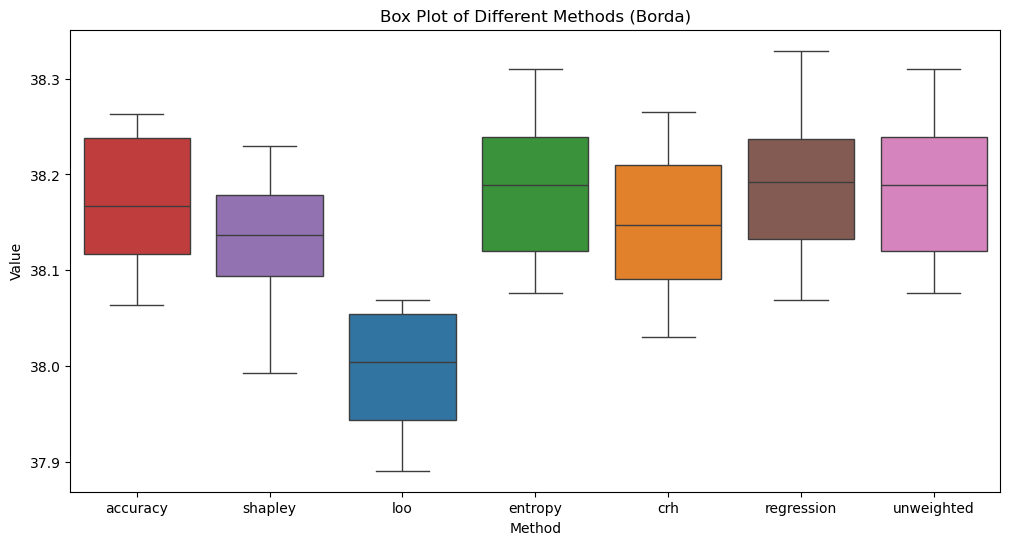

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Method', y='Value', data=accuracy_bordas_3_df_melted, palette=palette)
plt.title('Box Plot of Different Methods (Borda)')
plt.ylabel('Value')
plt.xlabel('Method')
plt.show()

/tmp/ipykernel_451125/1544515573.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Value', data=accuracy_plurality_3_df_melted, palette=palette)


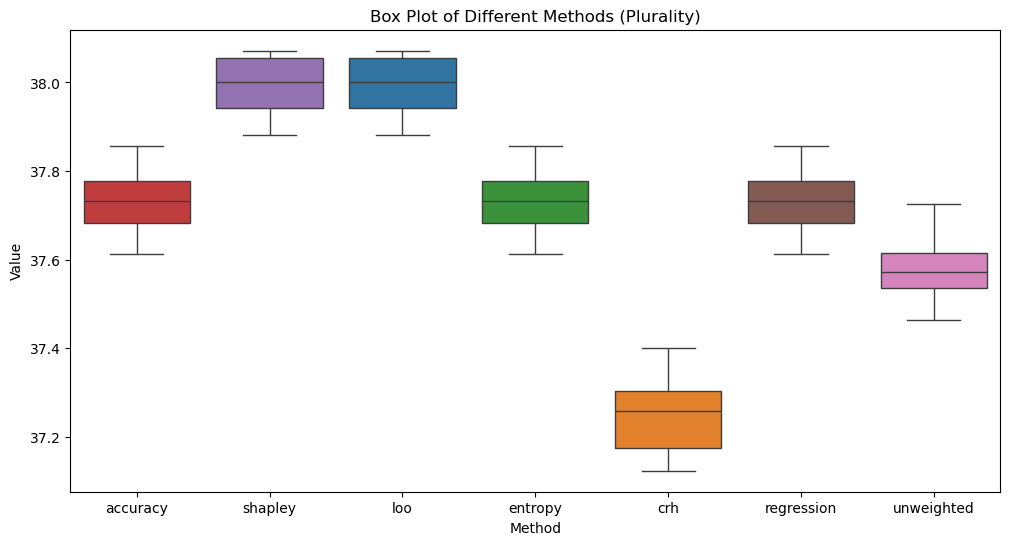

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Method', y='Value', data=accuracy_plurality_3_df_melted, palette=palette)
plt.title('Box Plot of Different Methods (Plurality)')
plt.ylabel('Value')
plt.xlabel('Method')
plt.show()

In [21]:
accuracy_bordas_5 = {key:accuracy_dict_5[key]['borda'] for key in accuracy_dict_5.keys()}
accuracy_plurality_5 = {key:accuracy_dict_5[key]['plurality'] for key in accuracy_dict_5.keys()}

accuracy_bordas_5_df = pd.DataFrame(accuracy_bordas_5)
accuracy_plurality_5_df = pd.DataFrame(accuracy_plurality_5)

# Assuming the data is stored in a DataFrame named accuracy_bordas_5_df
# Melt the DataFrame to a long format suitable for seaborn
accuracy_bordas_5_df_melted = accuracy_bordas_5_df.melt(var_name='Method', value_name='Value')
accuracy_plurality_5_df_melted = accuracy_plurality_5_df.melt(var_name='Method', value_name='Value')

# Define a custom color palette
palette = {
    'loo': '#1f77b4',        # Blue
    'crh': '#ff7f0e',        # Orange
    'entropy': '#2ca02c',    # Green
    'accuracy': '#d62728',   # Red
    'shapley': '#9467bd',    # Purple
    'regression': '#8c564b',  # Brown
    'unweighted': '#e377c2'  # Pink
}

/tmp/ipykernel_451125/866127261.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Value', data=accuracy_plurality_5_df_melted, palette=palette)


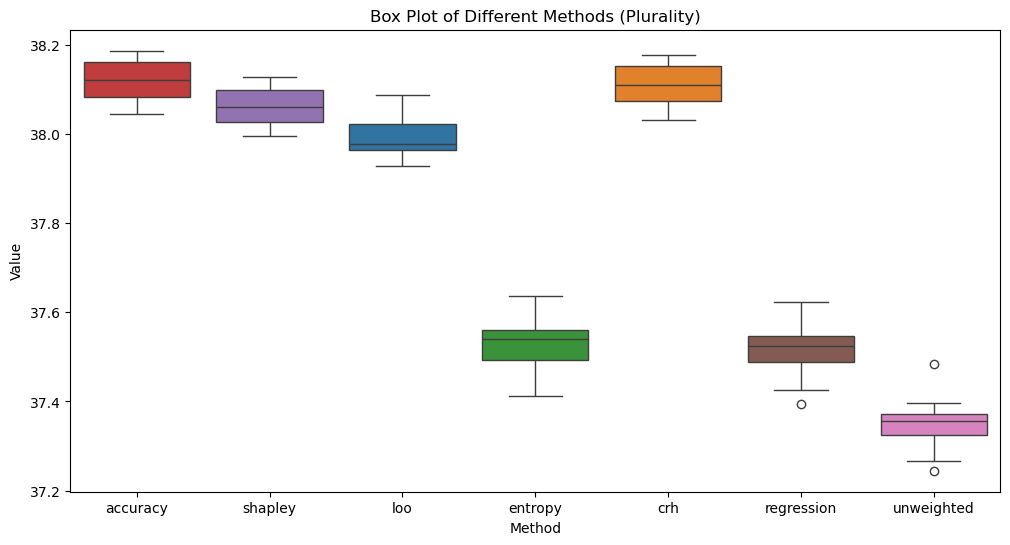

In [22]:
# Create a box plot with the custom palette
plt.figure(figsize=(12, 6))
sns.boxplot(x='Method', y='Value', data=accuracy_plurality_5_df_melted, palette=palette)
plt.title('Box Plot of Different Methods (Plurality)')
plt.ylabel('Value')
plt.xlabel('Method')
plt.show()

/tmp/ipykernel_451125/2006337391.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Value', data=accuracy_bordas_10_df_melted, palette=palette)


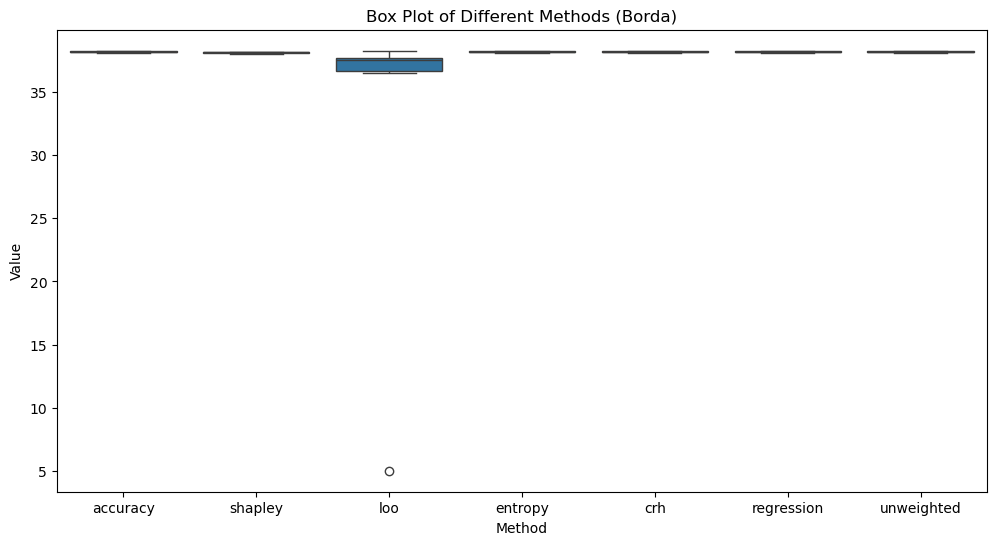

In [23]:
accuracy_bordas_10 = {key:accuracy_dict_10[key]['borda'] for key in accuracy_dict_10.keys()}
accuracy_plurality_10 = {key:accuracy_dict_10[key]['plurality'] for key in accuracy_dict_10.keys()}

accuracy_bordas_10_df = pd.DataFrame(accuracy_bordas_10)
accuracy_plurality_10_df = pd.DataFrame(accuracy_plurality_10)

# Assuming the data is stored in a DataFrame named accuracy_bordas_10_df
# Melt the DataFrame to a long format suitable for seaborn
accuracy_bordas_10_df_melted = accuracy_bordas_10_df.melt(var_name='Method', value_name='Value')
accuracy_plurality_10_df_melted = accuracy_plurality_10_df.melt(var_name='Method', value_name='Value')

# Define a custom color palette
palette = {
    'loo': '#1f77b4',        # Blue
    'crh': '#ff7f0e',        # Orange
    'entropy': '#2ca02c',    # Green
    'accuracy': '#d62728',   # Red
    'shapley': '#9467bd',    # Purple
    'regression': '#8c564b',  # Brown
    'unweighted': '#e377c2'  # Pink
}

# Create a box plot with the custom palette
plt.figure(figsize=(12, 6))
sns.boxplot(x='Method', y='Value', data=accuracy_bordas_10_df_melted, palette=palette)
plt.title('Box Plot of Different Methods (Borda)')
plt.ylabel('Value')
plt.xlabel('Method')
plt.show()

/tmp/ipykernel_451125/935400198.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Value', data=accuracy_plurality_10_df_melted, palette=palette)


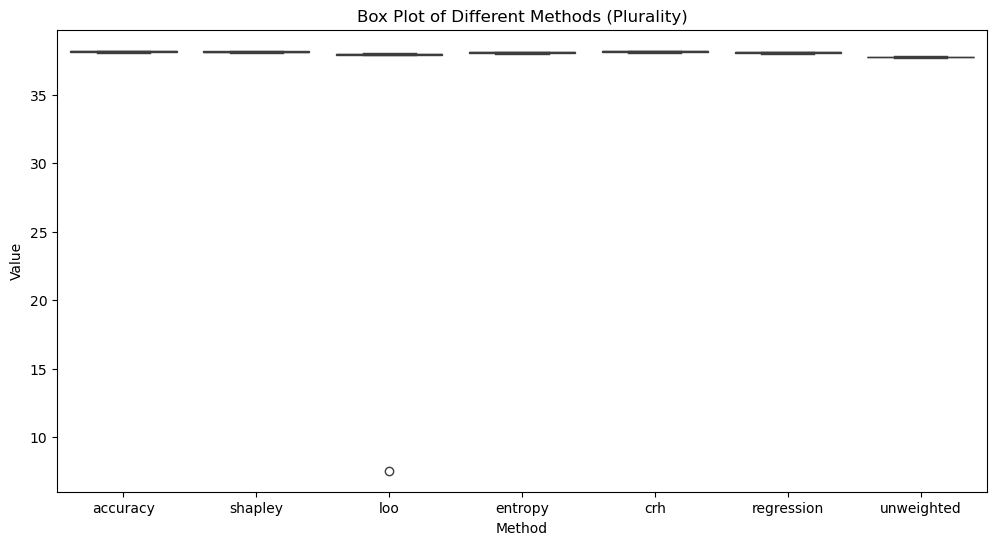

In [24]:
# Create a box plot with the custom palette
plt.figure(figsize=(12, 6))
sns.boxplot(x='Method', y='Value', data=accuracy_plurality_10_df_melted, palette=palette)
plt.title('Box Plot of Different Methods (Plurality)')
plt.ylabel('Value')
plt.xlabel('Method')
plt.show()

In [ ]:
# Save the dictionaries in a pickle file in destination folder dmoz_exps/ create the folder if it does not exist
import pickle
import os
if not os.path.exists('dmoz_exps'):
    os.makedirs('dmoz_exps')
with open('dmoz_exps/accuracy_dict_3.pkl', 'wb') as f:
    pickle.dump(accuracy_dict_3, f)
with open('dmoz_exps/accuracy_dict_5.pkl', 'wb') as f:
    pickle.dump(accuracy_dict_5, f)
with open('dmoz_exps/accuracy_dict_7.pkl', 'wb') as f:
    pickle.dump(accuracy_dict_7, f)
with open('dmoz_exps/accuracy_dict_10.pkl', 'wb') as f:
    pickle.dump(accuracy_dict_10, f)

# Load the dictionaries from the pickle file
with open('dmoz_exps/accuracy_dict_3.pkl', 'rb') as f:
    accuracy_dict_3 = pickle.load(f)
with open('dmoz_exps/accuracy_dict_5.pkl', 'rb') as f:
    accuracy_dict_5 = pickle.load(f)
with open('dmoz_exps/accuracy_dict_7.pkl', 'rb') as f:
    accuracy_dict_7 = pickle.load(f)
with open('dmoz_exps/accuracy_dict_10.pkl', 'rb') as f:
    accuracy_dict_10 = pickle.load(f)

### Test

In [25]:
divs = 5

X_train, X_test, y_train, y_test = stratified_train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
clfs = train_noisy_MNB(divs, X_train, y_train, unique_labels)
wf = WeightFinding_sklearn(clfs, [X_val, y_val], 'cpu')
wf_test = WeightFinding_sklearn(clfs, [X_test, y_test], 'cpu')

100%|██████████| 5/5 [00:00<00:00,  7.35it/s]


In [26]:
loo_weights = wf.loo()
shapley_weights = wf.shapley()
crh_weights = wf.crh()
regression_weights = wf.regression()
acc_weights = wf.accuracy_weights()
entropy_weights = wf.entropy_weights()

Calculating LOO values for 5 models
Calculating Shapley values for 5 models


  0%|          | 0/6 [00:00<?, ?it/s]/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pratik/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 5/5 [00:00<00:00, 40485.56it/s]


Calculating CRH values for 5 models
Calculating Regression weights for 5 models


100%|██████████| 1000/1000 [00:36<00:00, 27.61it/s]


Calculating Accuracy weights for 5 models
Calculating Entropy weights for 5 models


In [27]:
print(voting(wf_test.y_preds, wf_test.labels, acc_weights, method='borda'))
print(voting(wf_test.y_preds, wf_test.labels, acc_weights, method='plurality'))
print(voting(wf_test.y_preds, wf_test.labels, shapley_weights, method='borda'))
print(voting(wf_test.y_preds, wf_test.labels, shapley_weights, method='plurality'))
print(voting(wf_test.y_preds, wf_test.labels, loo_weights, method='borda'))
print(voting(wf_test.y_preds, wf_test.labels, loo_weights, method='plurality'))
print(voting(wf_test.y_preds, wf_test.labels, entropy_weights, method='borda'))
print(voting(wf_test.y_preds, wf_test.labels, entropy_weights, method='plurality'))
print(voting(wf_test.y_preds, wf_test.labels, crh_weights, method='borda'))
print(voting(wf_test.y_preds, wf_test.labels, crh_weights, method='plurality'))
print(voting(wf_test.y_preds, wf_test.labels, regression_weights, method='borda'))
print(voting(wf_test.y_preds, wf_test.labels, regression_weights, method='plurality'))
print(voting(wf_test.y_preds, wf_test.labels, weights = None, method='borda'))
print(voting(wf_test.y_preds, wf_test.labels, weights = None, method='plurality'))

38.18170185540627
38.13222435487311
38.11772232885476
38.070804009383664
38.08701215611004
37.99957346982299
38.12667946257198
37.483471955640866
38.178716144167204
38.11345702708467
38.16805288974195
37.46854339944551
38.12667946257198
37.27703134996801


In [37]:
np.mean(np.argmax(np.average(wf_test.y_preds, axis = 0, weights = regression_weights), axis = 1) == wf_test.labels)

0.3816805288974195

In [38]:
acc_weights

array([0.3802218 , 0.37876733, 0.36776285, 0.12501599, 0.06939646])